In [12]:
from scapy.all import * 
from scapy.all import ICMP, IP
import time
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

Creamos una función ping que envía echo_request al host pasado por parámetro. La función devuelve un diccionario que contiene la siguiente información:

* dst: Host contactado
* response: True si se obtuvo respuesta; False en caso contrario
* rtt_us: RTT en milisegundos (None si no se obtuvo respuesta)
* len: Longitud del paquete recibido (None si no se obtuvo respuesta)
* ttl: Time to live del paquete recibido (None si no se obtuvo respuesta)


In [2]:
def ping(host): 

    # Diccionario de códigos ICMP para respuestas de tipo 3 (Destino inalcanzable)
    codigos = {
        0: "Red de destino inalcanzable",
        1: "Host de destino inalcanzable",
        2: "Protocolo inalcanzable",
        3: "Puerto inalcanzable",
        4: "Fragmentación requerida y DF activado",
        5: "Ruta de origen fallida"}
    
    # Creo diccionario con valores por defecto
    data = {
        "dst": host,
        "response_type": None,
        "rtt_ms": None,
        "len": None,
        "ttl": None
    }
    
    print(f"Pinging {host}...")

    packet = IP(dst=host)/ICMP(type=8) # Echo Request
    
    inicio = time.time()
    response = sr1(packet, timeout=10, verbose=False) # sr1: envío y espero una sola respuesta
    fin = time.time()
    
    if response:

        icmp_layer = response.getlayer(ICMP)

        code = icmp_layer.code

        rtt_ms = (fin - inicio) * 1000 # RTT en milisegundos
        data["rtt_ms"] = rtt_ms
        data["len"] = response.len
        data["ttl"] = response.ttl
        data["response_type"] = response.type

        if response.type == 3: 
            print(f"Destino {host} inalcanzable: " + codigos[code])
        
        elif response.type == 0: # Si la respuesta es echo reply
            print(f"Echo-reply recibida de {host}")

        else:
            print(f"Respuesta ICMP recibida de tipo {response.type}, código {icmp_layer.code}")

    else:
        print(f"No se recibió respuesta de {host}")

    return data

In [3]:
def ping_multiple(host, cantidad_paquetes):

    res = dict()
    sent_packets = cantidad_paquetes
    received_packets = 0
    lost_packets = 0
    total_rtt = 0
    min_rtt = float('inf')
    max_rtt = float('-inf')
    lista_rtts = []
    
    for i in range(cantidad_paquetes):

        resultado = ping(host)

        # print(resultado) # podemos descomentar para ver el resultado de cada ping

        if resultado["response_type"] == 0: 
            received_packets += 1
            total_rtt += resultado["rtt_ms"]
            min_rtt = min(min_rtt, resultado["rtt_ms"])
            max_rtt = max(max_rtt, resultado["rtt_ms"])
            lista_rtts.append(resultado["rtt_ms"])

        else:
            lost_packets += 1 # Si el destino es inalcanzable o no se recibe respuesta, el ping se considera perdido

    res["host"] = host
    res["Paquetes enviados"] = sent_packets
    res["Paquetes recibidos"] = received_packets
    res["Paquetes perdidos"] = lost_packets
    res["Porcentaje de paquetes perdidos"] = (lost_packets / sent_packets) 
    res["RTT total"] = total_rtt if received_packets > 0 else None
    res["RTT mínimo"] = min_rtt if min_rtt != float('inf') else None
    res["RTT máximo"] = max_rtt if max_rtt != float('-inf') else None
    res["RTT promedio"] = total_rtt / received_packets if received_packets > 0 else None
    res["Desvió estándar del RTT promedio"] = statistics.stdev(lista_rtts) if len(lista_rtts) > 1 else None
    
    return res

Contactamos a 5 universidades de continentes distintos. También contactamos a UTDT para ver las diferencias.

In [4]:
ping_multiple('utdt.edu.ar', 5)


Pinging utdt.edu.ar...
Echo-reply recibida de utdt.edu.ar
Pinging utdt.edu.ar...
Echo-reply recibida de utdt.edu.ar
Pinging utdt.edu.ar...
Echo-reply recibida de utdt.edu.ar
Pinging utdt.edu.ar...
Echo-reply recibida de utdt.edu.ar
Pinging utdt.edu.ar...
Echo-reply recibida de utdt.edu.ar


{'host': 'utdt.edu.ar',
 'Paquetes enviados': 5,
 'Paquetes recibidos': 5,
 'Paquetes perdidos': 0,
 'Porcentaje de paquetes perdidos': 0.0,
 'RTT total': 88.81855010986328,
 'RTT mínimo': 13.510704040527344,
 'RTT máximo': 26.273012161254883,
 'RTT promedio': 17.763710021972656,
 'Desvió estándar del RTT promedio': 5.584849294006135}

In [5]:
ping_multiple('mit.edu', 5)

Pinging mit.edu...
Echo-reply recibida de mit.edu
Pinging mit.edu...
Echo-reply recibida de mit.edu
Pinging mit.edu...
Echo-reply recibida de mit.edu
Pinging mit.edu...
Echo-reply recibida de mit.edu
Pinging mit.edu...
Echo-reply recibida de mit.edu


{'host': 'mit.edu',
 'Paquetes enviados': 5,
 'Paquetes recibidos': 5,
 'Paquetes perdidos': 0,
 'Porcentaje de paquetes perdidos': 0.0,
 'RTT total': 220.15833854675293,
 'RTT mínimo': 41.71562194824219,
 'RTT máximo': 47.69563674926758,
 'RTT promedio': 44.031667709350586,
 'Desvió estándar del RTT promedio': 2.2269579775806285}

In [6]:
ping_multiple('ie.edu', 5)

Pinging ie.edu...
Echo-reply recibida de ie.edu
Pinging ie.edu...
Echo-reply recibida de ie.edu
Pinging ie.edu...
Echo-reply recibida de ie.edu
Pinging ie.edu...
Echo-reply recibida de ie.edu
Pinging ie.edu...
Echo-reply recibida de ie.edu


{'host': 'ie.edu',
 'Paquetes enviados': 5,
 'Paquetes recibidos': 5,
 'Paquetes perdidos': 0,
 'Porcentaje de paquetes perdidos': 0.0,
 'RTT total': 78.2005786895752,
 'RTT mínimo': 12.216329574584961,
 'RTT máximo': 19.249677658081055,
 'RTT promedio': 15.640115737915039,
 'Desvió estándar del RTT promedio': 2.6951080715652105}

In [7]:
ping_multiple('sydney.edu.au', 5)

Pinging sydney.edu.au...
Echo-reply recibida de sydney.edu.au
Pinging sydney.edu.au...
Echo-reply recibida de sydney.edu.au
Pinging sydney.edu.au...
Echo-reply recibida de sydney.edu.au
Pinging sydney.edu.au...
Echo-reply recibida de sydney.edu.au
Pinging sydney.edu.au...
Echo-reply recibida de sydney.edu.au


{'host': 'sydney.edu.au',
 'Paquetes enviados': 5,
 'Paquetes recibidos': 5,
 'Paquetes perdidos': 0,
 'Porcentaje de paquetes perdidos': 0.0,
 'RTT total': 1726.0704040527344,
 'RTT mínimo': 311.37752532958984,
 'RTT máximo': 464.94531631469727,
 'RTT promedio': 345.2140808105469,
 'Desvió estándar del RTT promedio': 67.01958398827482}

In [8]:
ping_multiple('cuhk.edu.cn', 5)

Pinging cuhk.edu.cn...
Echo-reply recibida de cuhk.edu.cn
Pinging cuhk.edu.cn...
Echo-reply recibida de cuhk.edu.cn
Pinging cuhk.edu.cn...
Echo-reply recibida de cuhk.edu.cn
Pinging cuhk.edu.cn...
Echo-reply recibida de cuhk.edu.cn
Pinging cuhk.edu.cn...
Echo-reply recibida de cuhk.edu.cn


{'host': 'cuhk.edu.cn',
 'Paquetes enviados': 5,
 'Paquetes recibidos': 5,
 'Paquetes perdidos': 0,
 'Porcentaje de paquetes perdidos': 0.0,
 'RTT total': 1586.1468315124512,
 'RTT mínimo': 315.85192680358887,
 'RTT máximo': 318.89843940734863,
 'RTT promedio': 317.22936630249023,
 'Desvió estándar del RTT promedio': 1.0923178177955848}

In [9]:
ping_multiple('uniben.edu', 5)

Pinging uniben.edu...
Echo-reply recibida de uniben.edu
Pinging uniben.edu...
Echo-reply recibida de uniben.edu
Pinging uniben.edu...
Echo-reply recibida de uniben.edu
Pinging uniben.edu...
Echo-reply recibida de uniben.edu
Pinging uniben.edu...
Echo-reply recibida de uniben.edu


{'host': 'uniben.edu',
 'Paquetes enviados': 5,
 'Paquetes recibidos': 5,
 'Paquetes perdidos': 0,
 'Porcentaje de paquetes perdidos': 0.0,
 'RTT total': 86.65609359741211,
 'RTT mínimo': 15.101432800292969,
 'RTT máximo': 18.94545555114746,
 'RTT promedio': 17.331218719482422,
 'Desvió estándar del RTT promedio': 1.8552017037511064}

In [10]:
#ping_multiple('bu.edu.eg',5)

In [11]:
ping_multiple('alexu.edu.eg', 5)

Pinging alexu.edu.eg...
No se recibió respuesta de alexu.edu.eg
Pinging alexu.edu.eg...
No se recibió respuesta de alexu.edu.eg
Pinging alexu.edu.eg...
No se recibió respuesta de alexu.edu.eg
Pinging alexu.edu.eg...
No se recibió respuesta de alexu.edu.eg
Pinging alexu.edu.eg...
No se recibió respuesta de alexu.edu.eg


{'host': 'alexu.edu.eg',
 'Paquetes enviados': 5,
 'Paquetes recibidos': 0,
 'Paquetes perdidos': 5,
 'Porcentaje de paquetes perdidos': 1.0,
 'RTT total': None,
 'RTT mínimo': None,
 'RTT máximo': None,
 'RTT promedio': None,
 'Desvió estándar del RTT promedio': None}

## Gráficos

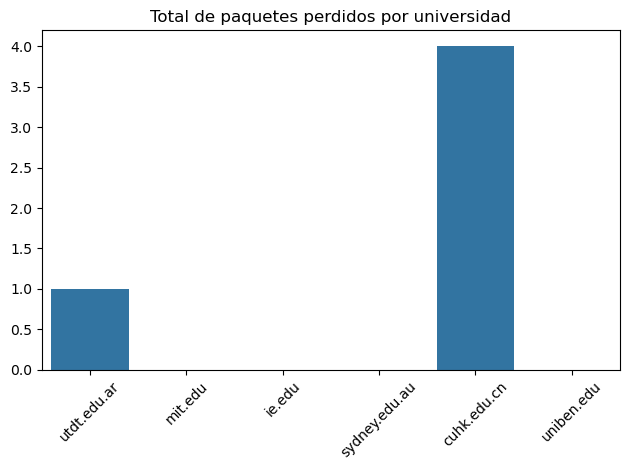

In [15]:
# Total de perdidos

total_perdidos = {'utdt.edu.ar': 1, 'mit.edu': 0, 'ie.edu': 0, 'sydney.edu.au':0, 'cuhk.edu.cn': 4, 'uniben.edu': 0}

sns.barplot(x=total_perdidos.keys(), y=total_perdidos.values())
plt.title('Total de paquetes perdidos por universidad')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()